In [1]:
import pandas as pd
import numpy as np
import requests
import os 
from dotenv import load_dotenv
import requests
from collections import Counter
from fuzzywuzzy import process, fuzz
from tqdm import tqdm
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

import src.biblioteca as bb
sys.path.append("../")
import src.soportecleaning as spcl

Note to self:
en este archivo van cosas que luego van a ser tres archivos distintos.
- Limpieza
- EDA
- Charts
- 
Recomendable separarlo y trabajarlo de forma independiente

# Input files

Base data file

In [2]:
with open('../data/pickle/dataset_usa_base.pickle', 'rb') as base_data:
    base_data = pickle.load(base_data)
print(base_data.shape)
base_data.head(1)

(455057, 9)


,title,rank,date,artist,url,region,chart,trend,streams
8246,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000


LastFM extraction

In [3]:
with open('../data/pickle/spotify_dataset_lastfm.pickle', 'rb') as data_lastfm:
    data_lastfm = pickle.load(data_lastfm)
data_lastfm.drop_duplicates(inplace=True)
print(data_lastfm.drop_duplicates().shape)
data_lastfm.head(1)

(14659, 17)


,url,artist,track,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4
8246,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap


Spotify extraction

In [4]:
with open('../data/pickle/spotify_dataset_audioFeatures.pickle', 'rb') as data_spotify:
    data_spotify = pickle.load(data_spotify)
data_spotify.drop_duplicates(inplace=True)
print(data_spotify.drop_duplicates().shape)
data_spotify.head(1)

(13989, 21)


,url,artist,track,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


# Merging all data

In [5]:
df = base_data.merge(data_lastfm, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          456306
left_only          0
right_only         0
dtype: int64

In [6]:
df.drop(['_merge'], axis = 1, inplace = True)
df = df.merge(data_spotify, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          442906
left_only      13924
right_only         0
dtype: int64

In [7]:
df.drop(['artist_y', 'track_x', 'artist', 'track_y', '_merge'], axis = 1, inplace= True)
df.rename({'artist_x':'artist'}, inplace=True, axis=1)
print(df.shape)
df.head(1)

(456830, 41)


,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


# Cleaning data

In [8]:
df.head(1)

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


Highest rank in list + Weeks in charts

In [9]:
lista_url = df['url'].unique().tolist()
len(lista_url)

14650

In [10]:
ranks = {
    'url':[],
    'highest_rank':[],
    'weeks_in_charts':[]
}

In [11]:
def highest_rank (url, row):
    return row[row['url'] == url].sort_values(by = 'rank').iloc[0,1]

In [12]:
def weeks_in_charts (url):
    return df[df['url'] == url].shape[0]

In [13]:
for url in tqdm(lista_url):
    ranks['url'].append(url)
    ranks['highest_rank'].append(df[df['url'] == url].sort_values(by = 'rank').iloc[0,1])
    ranks['weeks_in_charts'].append(df[df['url'] == url].shape[0])

100%|██████████| 14650/14650 [14:56<00:00, 16.34it/s]


In [14]:
print(len(ranks['url']), len(ranks['highest_rank']), len(ranks['weeks_in_charts']))

14650 14650 14650


In [15]:
df = df.merge(pd.DataFrame(ranks), on = 'url', indicator= True)
df.value_counts('_merge')

_merge
both          456830
left_only          0
right_only         0
dtype: int64

In [16]:
df.drop(['_merge'], axis = 1, inplace=True)

Main music genre

Primo los géneros de las canciones -- si no hubiera datos, cojo los valores del artista

In [17]:
df.head(1)

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,highest_rank,weeks_in_charts
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000,1,429


In [18]:
df['music_genre'] = np.where(df['aritist_genre_0'].isnull() == True, df['track_genre_0'].str.lower(), df['aritist_genre_0'].str.lower())
df['music_genre'].value_counts()

hip-hop         131641
pop              65166
rap              30438
country          25113
rnb              22598
                 ...  
wave                 1
calypso              1
southern rap         1
salsa                1
c                    1
Name: music_genre, Length: 363, dtype: int64

In [19]:
cuenta_generos = Counter(genres for genres in df['music_genre'])
print(f"Hay {len(cuenta_generos)} generos diferentes.")

Hay 2976 generos diferentes.


In [20]:
dict_genres = dict(cuenta_generos.most_common(24))

In [21]:
fuzz.ratio('hip-hop', "hip hop")

86

In [22]:
def music_genres(column, genres):
    max = 0
    for key in genres.keys():
        try:
            similar = fuzz.ratio(column, key)
            if similar > max:
                max = similar
                genre = key     
        except:
            return "other"
    if max > 60:
        return genre
    else:
        return "other"

In [23]:
df["clean_music_genre"] = df.apply(lambda x: music_genres(x["music_genre"], dict_genres), axis = 1)
df["clean_music_genre"].value_counts()

hip-hop             132882
other                91631
pop                  65166
rap                  30446
country              25295
rnb                  22649
trap                 19979
electronic           11784
indie                11121
rock                  6456
soul                  5459
acoustic              3902
indie pop             3526
classic rock          3410
jazz                  3110
k-pop                 2783
house                 2610
lo-fi                 2416
indie rock            2098
latin                 2065
female vocalists      1823
black metal           1772
cloud rap             1600
reggaeton             1443
seen live             1404
Name: clean_music_genre, dtype: int64

Gender from artists

ojo, hay un poco de error -- volver a pasarlo, pero solo con el nombre de los artistas (que no sean grupos)

In [24]:
df.sample(5)

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,highest_rank,weeks_in_charts,music_genre,clean_music_genre
263518,Bad Luck,21,2019-04-05,Khalid,https://open.spotify.com/track/2vsuel3g4zaLYSO...,United States,top200,NEW_ENTRY,986069.000,"08 Mar 2022, 00:48","15 Feb 2017, 19:38",Khalid Robinson is American singer/songwriter ...,Khalid Robinson is American singer/songwriter ...,rnb,pop,soul,alternative,alternative rnb,NaN,NaN,NaN,NaN,NaN,spotify:track:2vsuel3g4zaLYSOY0mOMbi,0.432,0.520,1.000,-5.515,0.000,0.055,0.277,0.371,0.138,0.303,164.047,audio_features,2vsuel3g4zaLYSOY0mOMbi,https://api.spotify.com/v1/tracks/2vsuel3g4zaL...,https://api.spotify.com/v1/audio-analysis/2vsu...,231653.000,4.000,21,17,rnb,rnb
190845,Go Crazy,200,2021-05-15,"Chris Brown, Young Thug",https://open.spotify.com/track/1IIKrJVP1C9N7iP...,United States,top200,NEW_ENTRY,219735.000,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/Chris+Brow...",,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:1IIKrJVP1C9N7iPtG6eOsK,0.755,0.578,0.000,-8.932,0.000,0.145,0.316,0.000,0.250,0.581,94.148,audio_features,1IIKrJVP1C9N7iPtG6eOsK,https://api.spotify.com/v1/tracks/1IIKrJVP1C9N...,https://api.spotify.com/v1/audio-analysis/1IIK...,176960.000,4.000,19,397,NaN,other
323541,Loco,15,2019-10-24,Beéle,https://open.spotify.com/track/2J9B63FawlTaPdg...,United States,viral50,MOVE_DOWN,NaN,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/Be%C3%A9le...",,Colombia,urbana,colombiano,urbano,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:2J9B63FawlTaPdg4eH5X03,0.820,0.565,6.000,-5.965,1.000,0.170,0.158,0.000,0.047,0.773,105.110,audio_features,2J9B63FawlTaPdg4eH5X03,https://api.spotify.com/v1/tracks/2J9B63FawlTa...,https://api.spotify.com/v1/audio-analysis/2J9B...,204000.000,4.000,4,27,colombia,other
414877,Kobe,9,2020-02-01,Chief Keef,https://open.spotify.com/track/1RkOJtrrYNeF5DL...,United States,viral50,MOVE_UP,NaN,"10 Nov 2013, 04:29","19 Apr 2012, 05:39","Keith Farrelle Cozart (born August 15, 1995), ...","Keith Farrelle Cozart (born August 15, 1995), ...",Hip-Hop,rap,drill,trap,hip hop,chief keef,rap,bang,billy,banned,spotify:track:7AwsFpSKXnW3IPEHFxktzL,0.853,0.769,5.000,-5.950,0.000,0.217,0.050,0.000,0.304,0.694,136.044,audio_features,7AwsFpSKXnW3IPEHFxktzL,https://api.spotify.com/v1/tracks/7AwsFpSKXnW3...,https://api.spotify.com/v1/audio-analysis/7Aws...,211787.000,4.000,9,11,hip-hop,hip-hop
78443,Ophelia,164,2017-01-09,The Lumineers,https://open.spotify.com/track/7bTwYGhBdSQ8vuX...,United States,top200,MOVE_UP,156254.000,"22 Jul 2022, 02:22","16 Nov 2010, 18:31",The Lumineers is an American folk rock band ba...,The Lumineers is an American folk rock band ba...,folk,indie,folk rock,american,rock,indie folk,alternative,americana,rock,folk,spotify:track:3d8y0t70g7hw2FOWl9Z4Fm,0.664,0.573,5.000,-6.519,1.000,0.028,0.613,0.000,0.086,0.566,76.023,audio_features,3d8y0t70g7hw2FOWl9Z4Fm,https://api.spotify.com/v1/tracks/3d8y0t70g7hw...,https://api.spotify.com/v1/audio-analysis/3d8y...,160097.000,4.000,144,43,folk,other


In [25]:
## funciona pero tiene un poco de error
def generos(col):
    for key, value in bb.dict_gender.items():
        for k in key:
            for item in value:
                try:
                    if item in col.lower():
                        return key
                except:
                    return np.nan
    return np.nan

In [26]:
def generos_2(col):
    for key, value in bb.dict_gender.items():
        try:
            if value in col.lower():
                return key
        except:
            return np.nan
    return np.nan

In [27]:
df.head(1)

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,highest_rank,weeks_in_charts,music_genre,clean_music_genre
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000,1,429,hip-hop,hip-hop


In [28]:
#df["gender"] = df.apply(lambda x: generos(x['content'], bb.dict_gender), axis=1)
df["gender"] = df['summary'].apply(generos)

In [29]:
df['gender'].value_counts() / df.shape[0]

male         0.535
female       0.140
group        0.111
non-binary   0.023
Name: gender, dtype: float64

Age from artist

-- taking the data from the summary

In [30]:
df['birthday'] =  df['content'].apply(lambda x: re.findall(r'\w{1,15} \d{1,2}, \d{4}',str(x))).str[0]
df['birthday'].value_counts()

December 2, 1998     10839
July 4, 1995         10700
January 23, 1998      9272
October 24, 1986      8719
December 18, 2001     7645
                     ...  
March 10, 1984           1
November 20, 1981        1
May 26, 2013             1
March 1, 1927            1
October 6, 2000          1
Name: birthday, Length: 983, dtype: int64

In [31]:
df.sample()

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,highest_rank,weeks_in_charts,music_genre,clean_music_genre,gender,birthday
162722,Need It,93,2020-06-08,"Migos, YoungBoy Never Broke Again",https://open.spotify.com/track/6mtjo5kIHKlboGE...,United States,top200,MOVE_DOWN,276914.000,NaN,"01 Jan 1970, 00:00","<a href=""https://www.last.fm/music/Migos,+You...",,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spotify:track:6mtjo5kIHKlboGE84lf1FJ,0.852,0.745,11.000,-3.667,0.000,0.171,0.031,0.000,0.082,0.897,148.007,audio_features,6mtjo5kIHKlboGE84lf1FJ,https://api.spotify.com/v1/tracks/6mtjo5kIHKlb...,https://api.spotify.com/v1/audio-analysis/6mtj...,195681.000,4.000,54,70,NaN,other,NaN,NaN


df.dtypes

In [32]:
df.dtypes

title                 object
rank                   int64
date                  object
artist                object
url                   object
region                object
chart                 object
trend                 object
streams              float64
published_track       object
published             object
summary               object
content               object
aritist_genre_0       object
aritist_genre_1       object
aritist_genre_2       object
aritist_genre_3       object
aritist_genre_4       object
track_genre_0         object
track_genre_1         object
track_genre_2         object
track_genre_3         object
track_genre_4         object
URI                   object
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo         

In [33]:
df['playlist_date'] = pd.to_datetime(df['date'])
df['birthday_date'] = pd.to_datetime(df['birthday'])

In [34]:
df['birthday_date'].value_counts()

1998-12-02    10839
1995-07-04    10700
1998-01-23     9272
1986-10-24     8719
2001-12-18     7645
              ...  
1984-03-10        1
1981-11-20        1
2013-05-26        1
1927-03-01        1
2000-10-06        1
Name: birthday_date, Length: 983, dtype: int64

In [35]:
from datetime import date

def calculate_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))

In [36]:
df['age'] = df['birthday_date'].apply(calculate_age)
df['age'].value_counts()

24.000     29035
27.000     24258
30.000     16589
23.000     13114
5.000      12234
           ...  
120.000        5
98.000         3
87.000         2
91.000         2
72.000         1
Name: age, Length: 105, dtype: int64

In [66]:
df['year'] = df['playlist_date'].dt.year
df['month'] = df['playlist_date'].dt.month

key and scale type mapping

In [37]:
df['key_mapped'] = df['key'].replace(bb.dict_keys)
df['mode_mapped'] = df['mode'].replace(bb.dict_scale)

In [38]:
df['key_mapped'].value_counts()

C♯, D♭    68419
C         46879
B         40295
G♯, A♭    40246
F♯, G♭    37605
G         37357
A♯, B♭    35056
F         33487
D         32692
A         31433
E         29324
D♯, E♭    10113
Name: key_mapped, dtype: int64

In [39]:
df['mode_mapped'].value_counts()

Major    266509
Minor    176397
Name: mode_mapped, dtype: int64

# EDA

Total number of rows and columns of the dataframe

In [44]:
df.shape

(456830, 52)

Counting duplicated rows

In [46]:
df.duplicated().sum()

547

Counting null values

In [41]:
df.isnull().sum() / df.shape[0]

title               0.000
rank                0.000
date                0.000
artist              0.000
url                 0.000
region              0.000
chart               0.000
trend               0.000
streams             0.200
published_track     0.430
published           0.003
summary             0.003
content             0.003
aritist_genre_0     0.145
aritist_genre_1     0.154
aritist_genre_2     0.159
aritist_genre_3     0.168
aritist_genre_4     0.176
track_genre_0       0.447
track_genre_1       0.459
track_genre_2       0.474
track_genre_3       0.485
track_genre_4       0.495
URI                 0.030
danceability        0.030
energy              0.030
key                 0.030
loudness            0.030
mode                0.030
speechiness         0.030
acousticness        0.030
instrumentalness    0.030
liveness            0.030
valence             0.030
tempo               0.030
type                0.030
id                  0.030
track_href          0.030
analysis_url

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456830 entries, 0 to 456829
Data columns (total 52 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   title              456830 non-null  object        
 1   rank               456830 non-null  int64         
 2   date               456830 non-null  object        
 3   artist             456830 non-null  object        
 4   url                456830 non-null  object        
 5   region             456830 non-null  object        
 6   chart              456830 non-null  object        
 7   trend              456830 non-null  object        
 8   streams            365689 non-null  float64       
 9   published_track    260423 non-null  object        
 10  published          455495 non-null  object        
 11  summary            455495 non-null  object        
 12  content            455495 non-null  object        
 13  aritist_genre_0    390645 non-null  object  

Main statistic values for numeric columns

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rank,456830.000,85.554,60.081,1.000,32.000,76.000,138.000,200.000
streams,365689.000,390303.783,278588.299,122488.000,236159.000,294892.000,434690.000,6146233.000
danceability,442906.000,0.696,0.145,0.073,0.607,0.715,0.798,0.981
energy,442906.000,0.604,0.160,0.000,0.504,0.609,0.722,0.999
key,442906.000,5.271,3.674,0.000,1.000,6.000,8.000,11.000
loudness,442906.000,-6.726,2.487,-38.855,-7.909,-6.366,-5.114,0.457
mode,442906.000,0.602,0.490,0.000,0.000,1.000,1.000,1.000
speechiness,442906.000,0.135,0.122,0.022,0.045,0.081,0.202,0.966
acousticness,442906.000,0.229,0.242,0.000,0.041,0.140,0.341,0.995
instrumentalness,442906.000,0.013,0.083,0.000,0.000,0.000,0.000,0.976


Main statistic values for categorical columns

In [49]:
df.describe(include='object').T

,count,unique,top,freq
title,456830,11842,Ric Flair Drip (& Metro Boomin),1960
date,456830,1826,2021-11-17,265
artist,456830,5213,Juice WRLD,10839
url,456830,14650,https://open.spotify.com/track/7sO5G9EABYOXQKN...,1974
region,456830,1,United States,456830
chart,456830,2,top200,365689
trend,456830,4,MOVE_DOWN,195761
published_track,260423,3712,"26 Dec 2021, 05:35",1778
published,455495,2461,"01 Jan 1970, 00:00",78717
summary,455495,5131,"Jarad Anthony Higgins (born December 2, 1998; ...",10839


# Questions / hypothesis

Firstly, both of the playlist will be splitted in different dataframes.

In [157]:
top200 = df[df['chart'] == 'top200']
viral50 = df[df['chart'] == 'viral50']

## Most streamed artists

I will look up both of the list and see if top artist are the same in both of the lists. As the `streams` column is not available in the `viral50`, so we will use the `weeks_in_charts` column, that counts the number of occurences on the lists.

In [62]:
top10 = df.groupby(['artist'])['streams'].sum().reset_index().sort_values(by = 'streams', ascending = False).head(10)
top10['ratio'] = top10['streams'] * 100 / (df[~df['streams'].isnull()]['streams'].sum())
top10

,artist,streams,ratio
3638,Post Malone,4966682478.000,3.480
1293,Drake,4697961521.000,3.292
2273,Juice WRLD,4400300033.000,3.083
4923,XXXTENTACION,3436491646.000,2.408
587,Billie Eilish,2892423843.000,2.027
317,Ariana Grande,2501369300.000,1.753
4686,Travis Scott,2479590219.000,1.737
2719,Lil Uzi Vert,2430469669.000,1.703
4415,Taylor Swift,1961042065.000,1.374
2449,Khalid,1896097253.000,1.328


In [64]:
top10_top200 = top200.groupby(['artist'])['weeks_in_charts'].sum().reset_index().sort_values(by = 'weeks_in_charts', ascending = False).head(5)
top10_top200

,artist,weeks_in_charts
1968,XXXTENTACION,7813306
1495,Post Malone,5982382
913,Juice WRLD,5836286
1869,Travis Scott,5342058
1111,Lil Uzi Vert,3951332


In [65]:
top10_viral50 =viral50.groupby(['artist'])['weeks_in_charts'].sum().reset_index().sort_values(by = 'weeks_in_charts', ascending = False).head(5)
top10_viral50

,artist,weeks_in_charts
2870,Offset,267483
3940,Travis Scott,150197
932,DaBaby,138915
476,Billie Eilish,137395
4147,YNW Melly,130382


As we see, both of them are different. We will see h the top artist evolve on the list on the given period. 

In [99]:
artist_top200 = df[df['artist'].isin(top10_top200['artist'].tolist())].groupby(['artist', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
artist_top200['date'] = artist_top200['year'].astype(str) + '/' + artist_top200['month'].astype(str)
artist_top200.head()

,artist,year,month,weeks_in_charts,date
45,Lil Uzi Vert,2017,1,27986,2017/1
105,Post Malone,2017,1,33573,2017/1
165,Travis Scott,2017,1,64938,2017/1
225,XXXTENTACION,2017,1,671,2017/1
46,Lil Uzi Vert,2017,2,23352,2017/2


In [100]:
artist_viral50 = df[df['artist'].isin(top10_viral50['artist'].tolist())].groupby(['artist', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
artist_viral50['date'] = artist_viral50['year'].astype(str) + '/' + artist_viral50['month'].astype(str)
artist_viral50.head()

,artist,year,month,weeks_in_charts,date
119,Travis Scott,2017,1,64938,2017/1
120,Travis Scott,2017,2,60991,2017/2
121,Travis Scott,2017,3,67282,2017/3
122,Travis Scott,2017,4,66080,2017/4
123,Travis Scott,2017,5,71017,2017/5


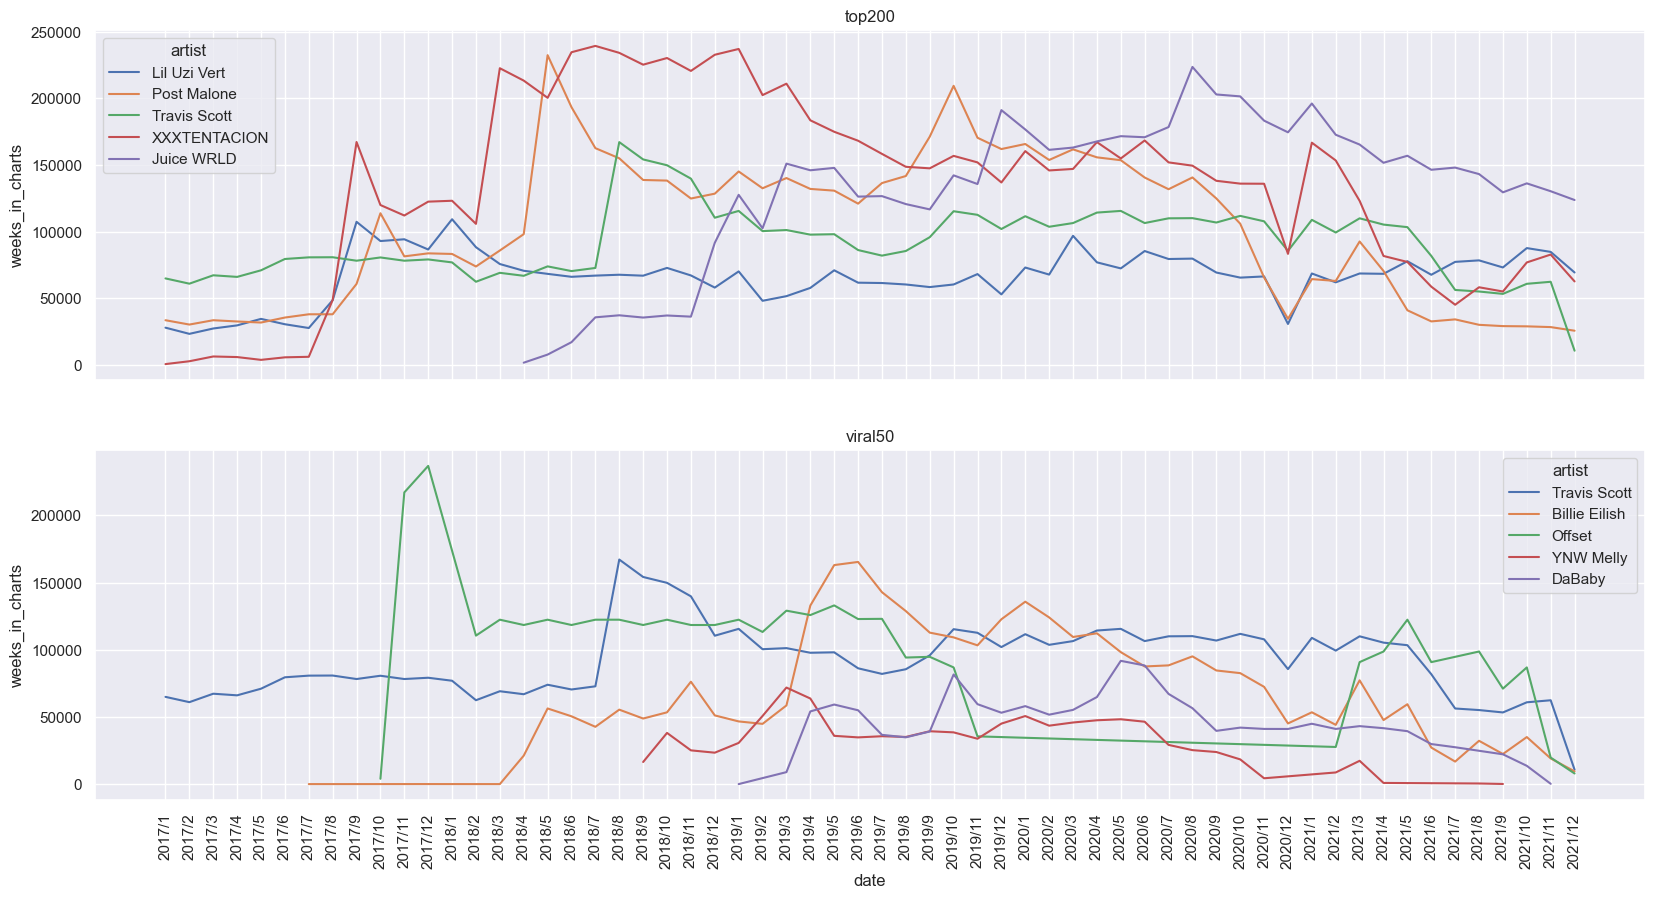

In [101]:
#sns.set_theme(style="darkgrid")
#sns.set(rc={"figure.figsize":(25,10)})
fig, axs = plt.subplots(ncols=1, nrows = 2, figsize = (20, 10), sharex = True)
g1 = sns.lineplot(x="date", y="weeks_in_charts", hue="artist",  data=artist_top200, ax=axs[0])
g2 = sns.lineplot(x="date", y="weeks_in_charts", hue="artist",  data=artist_viral50 , ax=axs[1])
axs[0].set_title('top200')
axs[1].set_title('viral50')
plt.xticks(rotation = 90);

## Most streamed music genres

In [102]:
df.head(1)

,title,rank,date,artist,url,region,chart,trend,streams,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,highest_rank,weeks_in_charts,music_genre,clean_music_genre,gender,birthday,playlist_date,birthday_date,age,key_mapped,mode_mapped,year,month
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,spotify:track:0M9ydKzuF3oZTfYYPfaGX1,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000,1,429,hip-hop,hip-hop,group,"June 15, 2013",2017-01-01,2013-06-15,9.000,B,Major,2017,1


In [113]:
top10_genre_top200 = top200.groupby(['clean_music_genre'])['weeks_in_charts'].sum().reset_index().sort_values(by = 'weeks_in_charts', ascending = False).head(11)
top10_genre_top200

,clean_music_genre,weeks_in_charts
7,hip-hop,48631875
17,pop,16048503
16,other,13264097
24,trap,9377017
18,rap,6449618
20,rnb,6304244
4,country,6274185
9,indie,2581116
5,electronic,1646245
15,lo-fi,1403647


In [114]:
top10_genre_viral50 =viral50.groupby(['clean_music_genre'])['weeks_in_charts'].sum().reset_index().sort_values(by = 'weeks_in_charts', ascending = False).head(11)
top10_genre_viral50

,clean_music_genre,weeks_in_charts
7,hip-hop,2504295
16,other,1966870
17,pop,1387853
18,rap,691408
24,trap,510706
20,rnb,335373
9,indie,323855
5,electronic,283197
4,country,211440
10,indie pop,119875


Let's see the music genre distribution.

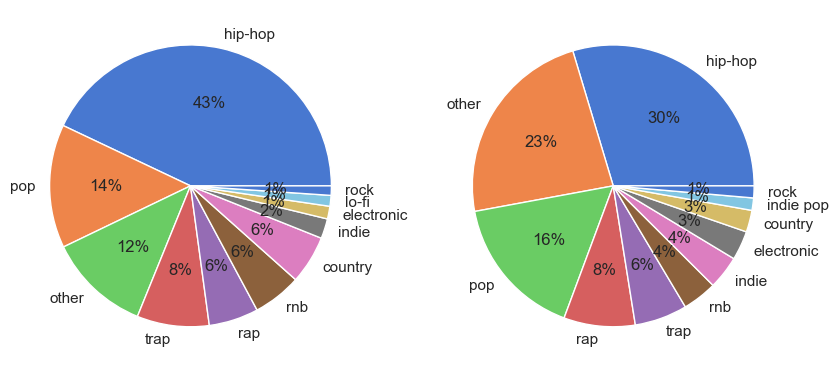

In [141]:
fig, axs = plt.subplots(ncols=2, nrows = 1, figsize = (10, 20), sharex = True)
axs0 = axs[0].pie(top10_genre_top200['weeks_in_charts'].tolist(), labels = top10_genre_top200['clean_music_genre'].tolist(), colors = sns.color_palette('muted'), autopct='%.0f%%')
axs1 = axs[1].pie(top10_genre_viral50['weeks_in_charts'].tolist(), labels = top10_genre_viral50['clean_music_genre'].tolist(), colors = sns.color_palette('muted'), autopct='%.0f%%')
plt.show()

In [105]:
genre_top200 = df.groupby(['clean_music_genre', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
genre_top200['date'] = genre_top200['year'].astype(str) + '/' + genre_top200['month'].astype(str)
genre_top200.head()

,clean_music_genre,year,month,weeks_in_charts,date
0,acoustic,2017,1,26662,2017/1
95,classic rock,2017,1,285,2017/1
194,country,2017,1,1730,2017/1
254,electronic,2017,1,49502,2017/1
314,female vocalists,2017,1,1962,2017/1


In [ ]:
artist_viral50 = df[df['artist'].isin(top10_viral50['artist'].tolist())].groupby(['artist', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
artist_viral50['date'] = artist_viral50['year'].astype(str) + '/' + artist_viral50['month'].astype(str)
artist_viral50.head()

,artist,year,month,weeks_in_charts,date
119,Travis Scott,2017,1,64938,2017/1
120,Travis Scott,2017,2,60991,2017/2
121,Travis Scott,2017,3,67282,2017/3
122,Travis Scott,2017,4,66080,2017/4
123,Travis Scott,2017,5,71017,2017/5


## Gender distibution

Let's see how genders  are distributed in both of the playlist.

In [153]:
top200.groupby(['gender'])['weeks_in_charts'].count().reset_index()

,gender,weeks_in_charts
0,female,50566
1,group,38473
2,male,209331
3,non-binary,9581


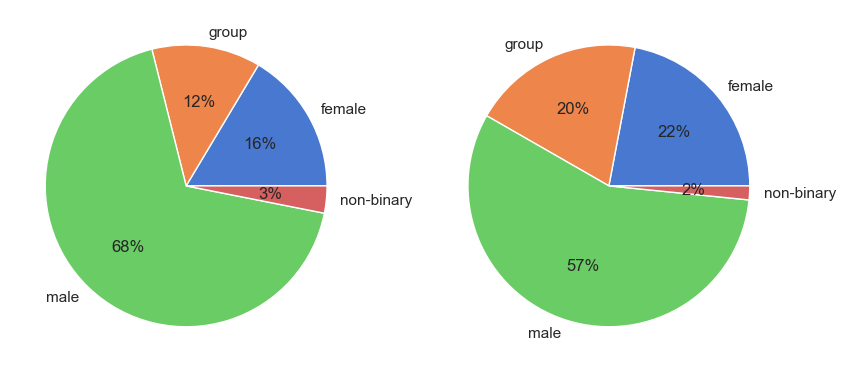

In [154]:
fig, axs = plt.subplots(ncols=2, nrows = 1, figsize = (10, 20), sharex = True)
axs0 = axs[0].pie(top200.groupby(['gender'])['weeks_in_charts'].count().reset_index()['weeks_in_charts'].tolist(), 
    labels = top200.groupby(['gender'])['weeks_in_charts'].count().reset_index()['gender'].tolist(), colors = sns.color_palette('muted'), autopct='%.0f%%')
axs1 = axs[1].pie(viral50.groupby(['gender'])['weeks_in_charts'].count().reset_index()['weeks_in_charts'].tolist(), 
    labels = viral50.groupby(['gender'])['weeks_in_charts'].count().reset_index()['gender'].tolist(), colors = sns.color_palette('muted'), autopct='%.0f%%')
plt.show()

Let's see the distribution of gender during the years.

In [160]:
gender_top200 = top200.groupby(['gender', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
gender_top200['date'] = gender_top200['year'].astype(str) + '/' + gender_top200['month'].astype(str)
gender_top200.head()

,gender,year,month,weeks_in_charts,date
0,female,2017,1,56365,2017/1
60,group,2017,1,91112,2017/1
120,male,2017,1,597631,2017/1
180,non-binary,2017,1,28047,2017/1
1,female,2017,2,54383,2017/2


In [159]:
gender_viral50 = viral50.groupby(['gender', 'year', 'month'])['weeks_in_charts'].sum().reset_index().sort_values(by=['year', 'month'], ascending = True)
gender_viral50['date'] = gender_viral50['year'].astype(str) + '/' + gender_viral50['month'].astype(str)
gender_viral50.head()

,gender,year,month,weeks_in_charts,date
0,female,2017,1,5938,2017/1
60,group,2017,1,1573,2017/1
120,male,2017,1,11216,2017/1
180,non-binary,2017,1,56,2017/1
1,female,2017,2,7244,2017/2


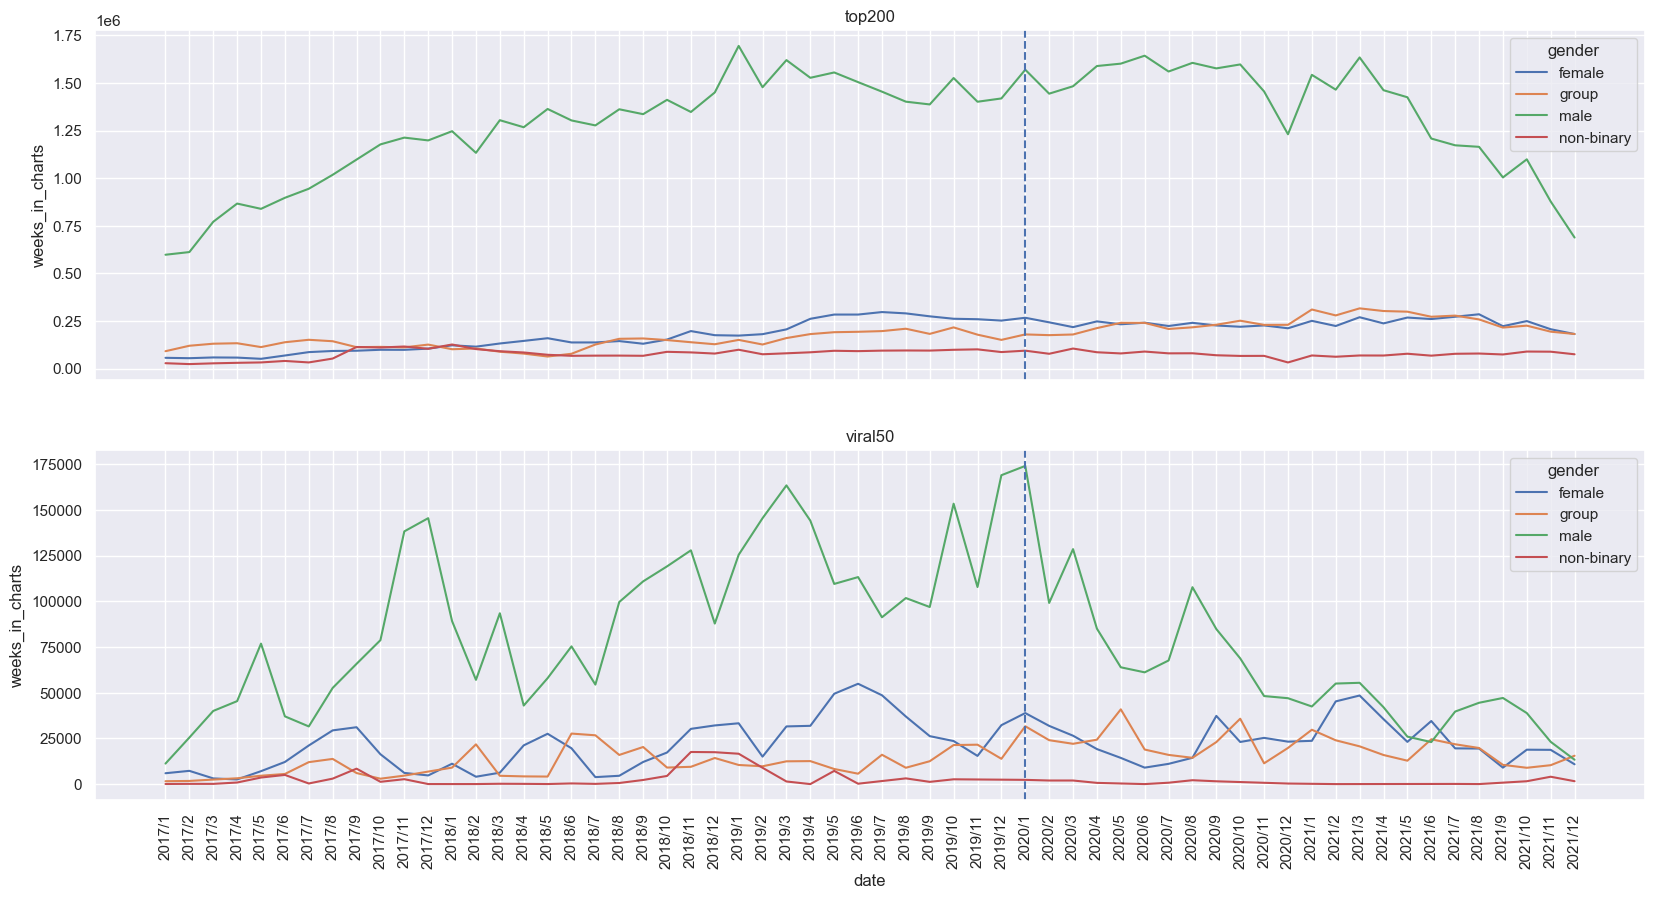

In [175]:
#sns.set_theme(style="darkgrid")
#sns.set(rc={"figure.figsize":(25,10)})
fig, axs = plt.subplots(ncols=1, nrows = 2, figsize = (20, 10), sharex = True)
g1 = sns.lineplot(x="date", y="weeks_in_charts", hue="gender",  data=gender_top200, ax=axs[0])
g2 = sns.lineplot(x="date", y="weeks_in_charts", hue="gender",  data=gender_viral50 , ax=axs[1])
axs[0].set_title('top200')
axs[1].set_title('viral50')
axs[0].axvline('2020/1', 0, max(gender_viral50['weeks_in_charts']), linestyle='dashed')
axs[1].axvline('2020/1', 0, max(gender_viral50['weeks_in_charts']), linestyle='dashed')
plt.xticks(rotation = 90);

In the `top200` there seems to be no advanced. The music displayed by this playlist is mostly male dominated. However, in the `viral50` playlist there seems to be hope for females. 

## Genres and genders

## How was the music during covid

## Artist evolution

In [ ]:
lista_artistas = list(top10['artist'])
df_top10 = df[df['artist'].isin(lista_artistas)]
df_top10.head()

In [ ]:
num_rows = 20
years = list(range(1990, 1990 + num_rows))
data_preproc = pd.DataFrame({
    'Year': years, 
    'A': np.random.randn(num_rows).cumsum(),
    'B': np.random.randn(num_rows).cumsum(),
    'C': np.random.randn(num_rows).cumsum(),
    'D': np.random.randn(num_rows).cumsum()})

In [ ]:
sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))

In [ ]:
test = pd.pivot_table(df_top10[df_top10['chart'] == 'top200'][['date', 'artist', 'rank']], index = 'date', values = ['rank'], columns = 'artist').reset_index().droplevel(level=0, axis =1)
test.rename({'':'date'}, axis = 1, inplace=True)
print(test.shape)
test.head()

In [ ]:
sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))

In [ ]:
sns.set(rc={'figure.figsize':(50,8.27)})

c = sns.lineplot(data = test, x = test['date'].unique().tolist(), y = 'Ariana Grande')
c.set_xticklabels(labels = test['date'].unique().tolist(), rotation=90)